# Variational inference (VI) in Turing.jl

In this post we'll have a look at what's know as **variational inference (VI)**, a family of _approximate_ Bayesian inference methods, and how to use it in Turing.jl as an alternative to other approaches such as MCMC. In particular, we will focus on one of the more standard VI methods called **Automatic Differentation Variational Inference (ADVI)**.

Here we will focus on how to use VI in Turing and not much on the theory underlying VI. If you're interested in understanding the mathematics you can checkout [our write-up](../../docs/for-developers/variational_inference) or any other resource online (there a lot of great ones).

Using VI in Turing.jl is very straight forward. If `model` denotes a definition of a `Turing.Model`, performing VI is as simple as
```julia
m = model(data...) # instantiate model on the data
q = vi(m, vi_alg)  # perform VI on `m` using the VI method `vi_alg`, which returns a `VariationalPosterior`
```
Thus it's no more work than standard MCMC sampling in Turing.

To get a bit more into what we can do with `vi`, we'll first have a look at a simple example and then we'll reproduce the [tutorial on Bayesian linear regression](../../tutorials/5-linearregression) using VI instead of MCMC. Finally we'll look at some of the different parameters of `vi` and how you for example can use your own custom variational family.

## Setup

In [1]:
using Random
using Turing
using Turing: Variational

Random.seed!(42);

## Simple example: Normal-Gamma conjugate model

The Normal-(Inverse)Gamma conjugate model is defined by the following generative process

\begin{align}
    s &\sim \mathrm{InverseGamma}(2, 3) \\
    m &\sim \mathcal{N}(0, s) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, s), \quad i = 1, \dots, n
\end{align}

Recall that *conjugate* refers to the fact that we can obtain a closed-form expression for the posterior. Of course one wouldn't use something like variational inference for a conjugate model, but it's useful as a simple demonstration as we can compare the result to the true posterior.

First we generate some synthetic data, define the `Turing.Model` and instantiate the model on the data:

In [2]:
# generate data, n = 2000
x = randn(2000);

In [3]:
@model model(x) = begin
    s ~ InverseGamma(2, 3)
    m ~ Normal(0.0, sqrt(s))
    for i = 1:length(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

##model#344 (generic function with 2 methods)

In [4]:
# construct model
m = model(x);

Now we'll produce some samples from the posterior using a MCMC method, which in constrast to VI is guaranteed to converge to the *exact* posterior (as the number of samples go to infinity).

We'll produce 10 000 samples with 200 steps used for adaptation and a target acceptance rate of 0.65

If you don't understand what "adaptation" or "target acceptance rate" refers to, all you really need to know is that `NUTS` is known to be one of the most accurate and efficient samplers (when applicable) while requiring little to no hand-tuning to work well.

In [5]:
samples_nuts = sample(m, NUTS(200, 0.65), 10000);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/cameron/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Now let's try VI. The most important function you need to now about to do VI in Turing is `vi`:

In [6]:
print(@doc(Variational.vi))

```
vi(model, alg::VariationalInference)
vi(model, alg::VariationalInference, q::VariationalPosterior)
vi(model, alg::VariationalInference, getq::Function, θ::AbstractArray)
```

Constructs the variational posterior from the `model` and performs the optimization following the configuration of the given `VariationalInference` instance.

# Arguments

  * `model`: `Turing.Model` or `Function` z ↦ log p(x, z) where `x` denotes the observations
  * `alg`: the VI algorithm used
  * `q`: a `VariationalPosterior` for which it is assumed a specialized implementation of the variational objective used exists.
  * `getq`: function taking parameters `θ` as input and returns a `VariationalPosterior`
  * `θ`: only required if `getq` is used, in which case it is the initial parameters for the variational posterior


`vi` takes the `Model` you want to approximate, a `VariationalInference` whose type specifies the method to use and then its fields specify the configuration of the method. 

Additionally, you can pass
- an initial variational posterior `q`, for which we assume there exists a implementation of `update(::typeof(q), θ::AbstractVector)` returning an updated posterior `q` with parameters `θ`.
- a function mapping $\theta \mapsto q_{\theta}$ (denoted above `getq`) together with initial parameters `θ`. This provides more flexibility in the types of variational families that we can use, and can sometimes be slightly more convenient for quick and rough work.

By default, i.e. when calling `vi(m, advi)`, Turing use a *mean-field* approximation with a multivariate normal as the base-distribution. Mean-field refers to the fact that we assume all the latent variables to be *independent*. This the "standard" ADVI approach; see [Automatic Differentiation Variational Inference (2016)](https://arxiv.org/abs/1603.00788) for more. In Turing, one can obtain such a mean-field approximation by calling `Variational.meanfield(model)` for which there exists an internal implementation for `update`:

In [7]:
print(@doc(Variational.meanfield))

```
meanfield(model::Model)
meanfield(rng::AbstractRNG, model::Model)
```

Creates a mean-field approximation with multivariate normal as underlying distribution.


Currently the only implementation of `VariationalInference` available is `ADVI`, which is very convenient and applicable as long as your `Model` is differentiable with respect to the *variational parameters*, that is, the parameters of your variational distribution, e.g. mean and variance in the mean-field approximation.

In [8]:
print(@doc(Variational.ADVI))

```julia
struct ADVI{AD} <: Turing.Variational.VariationalInference{AD}
```

Automatic Differentiation Variational Inference (ADVI) with automatic differentiation backend `AD`.

# Fields

  * `samples_per_step::Int64`

    Number of samples used to estimate the ELBO in each optimization step.
  * `max_iters::Int64`

    Maximum number of gradient steps.

```
ADVI([samples_per_step=1, max_iters=1000])
```

Create an [`ADVI`](@ref) with the currently enabled automatic differentiation backend `ADBackend()`.


To perform VI on the model `m` using 10 samples for gradient estimation and taking 1000 gradient steps is then as simple as:

In [9]:
# ADVI
advi = ADVI(10, 1000)
q = vi(m, advi);

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 12334556482979097499
└ @ Turing.Variational /home/cameron/.julia/packages/Turing/cReBm/src/variational/VariationalInference.jl:204
[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:03


Unfortunately, for such a small problem Turing's new `NUTS` sampler is *so* efficient now that it's not that much more efficient to use ADVI. So, so very unfortunate...

With that being said, this is not the case in general. For very complex models we'll later find that `ADVI` produces very reasonable results in a much shorter time than `NUTS`.

And one significant advantage of using `vi` is that we can sample from the resulting `q` with ease. In fact, the result of the `vi` call is a `TransformedDistribution` from Bijectors.jl, and it implements the Distributions.jl interface for a `Distribution`:

In [10]:
q isa MultivariateDistribution

true

This means that we can call `rand` to sample from the variational posterior `q`

In [11]:
rand(q)

2-element Array{Float64,1}:
  1.0134702063474585
 -0.07429020521027016

and `logpdf` to compute the log-probability

In [12]:
logpdf(q, rand(q))

4.277478745320889

Let's check the first and second moments of the data to see how our approximation compares to the point-estimates form the data:

In [13]:
var(x), mean(x)

(1.021109459575047, -0.028838703049547422)

In [14]:
(mean(rand(q, 1000); dims = 2)..., )

(1.02716749432684, -0.02510701319723139)

That's pretty close! But we're Bayesian so we're not interested in *just* matching the mean.
Let's instead look the actual density `q`. 

For that we need samples:

In [15]:
samples = rand(q, 10000);

In [16]:
# setup for plotting
using Plots, LaTeXStrings, StatsPlots
pyplot()

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


Plots.PyPlotBackend()

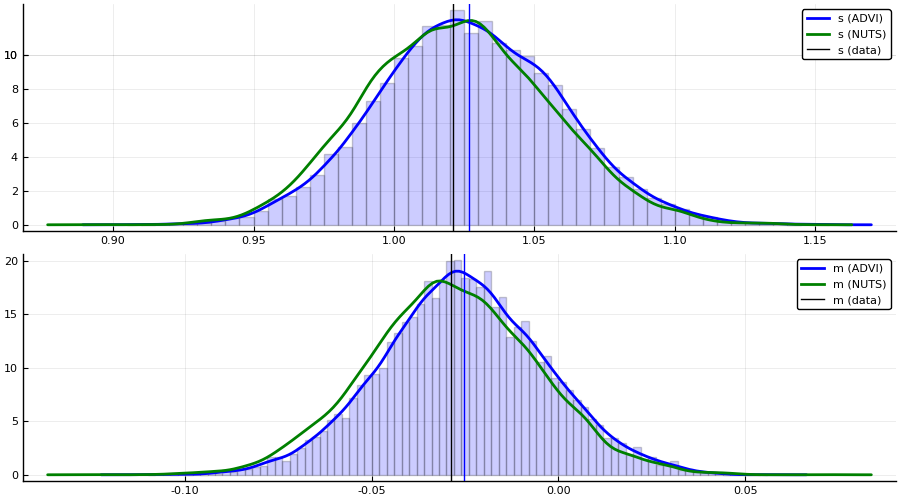

In [17]:
p1 = histogram(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue, linewidth = 2)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green, linewidth = 2)
vline!([var(x)], label = "s (data)", color = :black)
vline!([mean(samples[1, :])], color = :blue, label ="")

p2 = histogram(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue, linewidth = 2)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green, linewidth = 2)
vline!([mean(x)], color = :black, label = "m (data)")
vline!([mean(samples[2, :])], color = :blue, label="")

plot(p1, p2, layout=(2, 1), size=(900, 500))

For this particular `Model`, we can in fact obtain the posterior of the latent variables in closed form. This allows us to compare both `NUTS` and `ADVI` to the true posterior $p(s, m \mid \{x_i\}_{i = 1}^n )$.

*The code below is just work to get the marginals $p(s \mid \{x_i\}_{i = 1}^n)$ and $p(m \mid \{x_i\}_{i = 1}^n$ from the posterior obtained using ConjugatePriors.jl. Feel free to skip it.*

┌ Info: Precompiling ConjugatePriors [1624bea9-42b1-5fc1-afd3-e96f729c8d6c]
└ @ Base loading.jl:1260


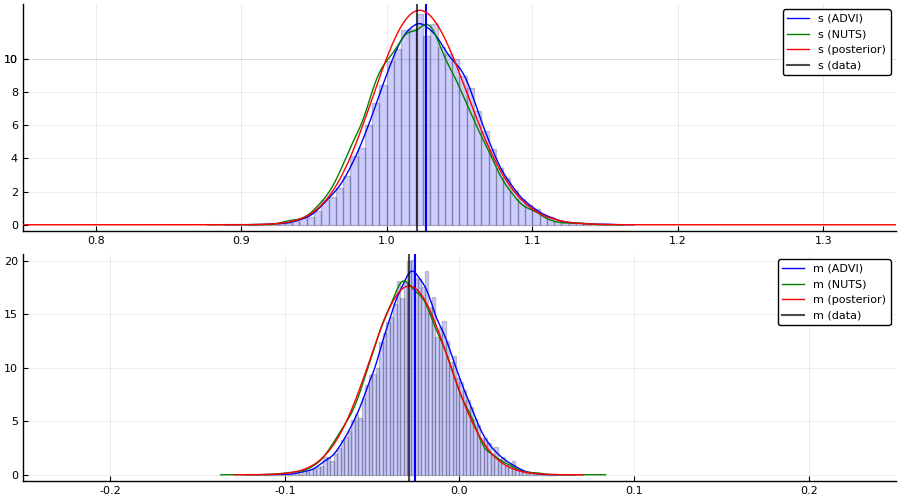

In [18]:
# used to compute closed form expression of posterior
using ConjugatePriors

# closed form computation
# notation mapping has been verified by explicitly computing expressions
# in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
μ₀ = 0.0 # => μ
κ₀ = 1.0 # => ν, which scales the precision of the Normal
α₀ = 2.0 # => "shape"
β₀ = 3.0 # => "rate", which is 1 / θ, where θ is "scale"

# prior
pri = NormalGamma(μ₀, κ₀, α₀, β₀)

# posterior
post = posterior(pri, Normal, x)

# marginal distribution of τ = 1 / σ²
# Eq. (90) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
# `scale(post)` = θ
p_τ = Gamma(post.shape, scale(post))
p_σ²_pdf = z -> pdf(p_τ, 1 / z) # τ => 1 / σ² 

# marginal of μ
# Eq. (91) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
p_μ = TDist(2 * post.shape)

μₙ = post.mu    # μ → μ
κₙ = post.nu    # κ → ν
αₙ = post.shape # α → shape
βₙ = post.rate  # β → rate

# numerically more stable but doesn't seem to have effect; issue is probably internal to
# `pdf` which needs to compute ≈ Γ(1000) 
p_μ_pdf = z -> exp(logpdf(p_μ, (z - μₙ) * exp(- 0.5 * log(βₙ) + 0.5 * log(αₙ) + 0.5 * log(κₙ))))

# posterior plots
p1 = plot();
histogram!(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green)
vline!([mean(samples[1, :])], linewidth = 1.5, color = :blue, label ="")

# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.001
r = 0.75:0.001:1.50
norm_const = sum(p_σ²_pdf.(r) .* Δ)
plot!(r, p_σ²_pdf, label = "s (posterior)", color = :red);
vline!([var(x)], label = "s (data)", linewidth = 1.5, color = :black, alpha = 0.7);
xlims!(0.75, 1.35);

p2 = plot();
histogram!(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green)
vline!([mean(samples[2, :])], linewidth = 1.5, color = :blue, label="")


# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.0001
r = -0.1 + mean(x):Δ:0.1 + mean(x)
norm_const = sum(p_μ_pdf.(r) .* Δ)
plot!(r, z -> p_μ_pdf(z) / norm_const, label = "m (posterior)", color = :red);
vline!([mean(x)], label = "m (data)", linewidth = 1.5, color = :black, alpha = 0.7);

xlims!(-0.25, 0.25);

p = plot(p1, p2; layout=(2, 1), size=(900, 500))

# Bayesian linear regression example using `ADVI`

This is simply a duplication of the tutorial [5. Linear regression](../../tutorials/5-linearregression) but now with the addition of an approximate posterior obtained using `ADVI`.

As we'll see, there is really no additional work required to apply variational inference to a more complex `Model`.

## Copy-paste from [5. Linear regression](../../tutorials/5-linearregression)

This section is basically copy-pasting the code from the [linear regression tutorial](../../tutorials/5-linearregression).

In [19]:
Random.seed!(1);

In [20]:
# Import RDatasets.
using RDatasets

# Hide the progress prompt while sampling.
Turing.turnprogress(true);

┌ Info: [Turing]: progress logging is enabled globally
└ @ Turing /home/cameron/.julia/packages/Turing/cReBm/src/Turing.jl:22


In [21]:
# Import the "Default" dataset.
data = RDatasets.dataset("datasets", "mtcars");

# Show the first six rows of the dataset.
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


In [22]:
# Function to split samples.
function split_data(df, at = 0.70)
    r = size(df,1)
    index = Int(round(r * at))
    train = df[1:index, :]
    test  = df[(index+1):end, :]
    return train, test
end

# A handy helper function to rescale our dataset.
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

# Another helper function to unstandardize our datasets.
function unstandardize(x, orig)
    return (x .+ mean(orig, dims=1)) .* std(orig, dims=1)
end

unstandardize (generic function with 1 method)

In [23]:
# Remove the model column.
select!(data, Not(:Model))

# Standardize our dataset.
(std_data, data_arr) = standardize(Matrix(data))

# Split our dataset 70%/30% into training/test sets.
train, test = split_data(std_data, 0.7)

# Save dataframe versions of our dataset.
train_cut = DataFrame(train, names(data))
test_cut = DataFrame(test, names(data))

# Create our labels. These are the values we are trying to predict.
train_label = train_cut[:, :MPG]
test_label = test_cut[:, :MPG]

# Get the list of columns to keep.
remove_names = filter(x->!in(x, [:MPG, :Model]), names(data))

# Filter the test and train sets.
train = Matrix(train_cut[:,remove_names]);
test = Matrix(test_cut[:,remove_names]);

In [24]:
# Bayesian linear regression.
@model linear_regression(x, y, n_obs, n_vars, ::Type{T}=Vector{Float64}) where {T} = begin
    # Set variance prior.
    σ₂ ~ truncated(Normal(0,100), 0, Inf)
    
    # Set intercept prior.
    intercept ~ Normal(0, 3)
    
    # Set the priors on our coefficients.
    coefficients ~ MvNormal(zeros(n_vars), 10 * ones(n_vars))
    
    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    y ~ MvNormal(mu, σ₂)
end;

In [25]:
n_obs, n_vars = size(train)
m = linear_regression(train, train_label, n_obs, n_vars);

## Performing VI

First we define the initial variational distribution, or, equivalently, the family of distributions to consider. We're going to use the same mean-field approximation as Turing will use by default when we call `vi(m, advi)`, which we obtain by calling `Variational.meanfield`. This returns a `TransformedDistribution` with a `TuringDiagMvNormal` as the underlying distribution and the transformation mapping from the reals to the domain of the latent variables.

In [26]:
q0 = Variational.meanfield(m)
typeof(q0)

Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Bijectors.Stacked{Tuple{Bijectors.Inverse{Bijectors.TruncatedBijector{Float64},0},Bijectors.Identity{0},Bijectors.Identity{1}},3},Multivariate}

In [27]:
advi = ADVI(10, 10_000)

ADVI{Turing.Core.ForwardDiffAD{40}}(10, 10000)

Turing also provides a couple of different optimizers:
- `TruncatedADAGrad` (default)
- `DecayedADAGrad`
as these are well-suited for problems with high-variance stochastic objectives, which is usually what the ELBO ends up being at different times in our optimization process.

With that being said, thanks to Requires.jl, if we add a `using Flux` prior to `using Turing` we can also make use of all the optimizers in `Flux`, e.g. `ADAM`, without any additional changes to your code! For example:
```julia
using Flux, Turing
using Turing.Variational

vi(m, advi; optimizer = Flux.ADAM())
```
just works.

For this problem we'll use the `DecayedADAGrad` from Turing:

In [28]:
opt = Variational.DecayedADAGrad(1e-2, 1.1, 0.9)

Turing.Variational.DecayedADAGrad(0.01, 1.1, 0.9, IdDict{Any,Any}())

In [29]:
q = vi(m, advi, q0; optimizer = opt)
typeof(q)

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:05


Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Bijectors.Stacked{Tuple{Bijectors.Inverse{Bijectors.TruncatedBijector{Float64},0},Bijectors.Identity{0},Bijectors.Identity{1}},3},Multivariate}

*Note: as mentioned before, we internally define a `update(q::TransformedDistribution{<:TuringDiagMvNormal}, θ::AbstractVector)` method which takes in the current variational approximation `q` together with new parameters `z` and returns the new variational approximation. This is required so that we can actually update the `Distribution` object after each optimization step.*

*Alternatively, we can instead provide the mapping $\theta \mapsto q_{\theta}$ directly together with initial parameters using the signature `vi(m, advi, getq, θ_init)` as mentioned earlier. We'll see an explicit example of this later on!*

To compute statistics for our approximation we need samples:

In [30]:
z = rand(q, 10_000);

Now we can for example look at the average

In [31]:
avg = vec(mean(z; dims = 2))

12-element Array{Float64,1}:
  0.4606389176400052
  0.05202909837745655
  0.4064267006145497
 -0.11468688188714653
 -0.09745310785481277
  0.6148587707658169
  0.01308179579131569
  0.09698898180610954
 -0.07232304322690832
  0.13320265040493984
  0.28561578772443025
 -0.829825963610117

The vector has the same ordering as the model, e.g. in this case `σ₂` has index `1`, `intercept` has index `2` and `coefficients` has indices `3:12`. If  you forget or you might want to do something programmatically with the result, you can obtain the `sym → indices` mapping as follows:

In [32]:
_, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
sym2range

(intercept = UnitRange{Int64}[2:2], σ₂ = UnitRange{Int64}[1:1], coefficients = UnitRange{Int64}[3:12])

In [33]:
avg[union(sym2range[:σ₂]...)]

1-element Array{Float64,1}:
 0.4606389176400052

In [34]:
avg[union(sym2range[:intercept]...)]

1-element Array{Float64,1}:
 0.05202909837745655

In [35]:
avg[union(sym2range[:coefficients]...)]

10-element Array{Float64,1}:
  0.4064267006145497
 -0.11468688188714653
 -0.09745310785481277
  0.6148587707658169
  0.01308179579131569
  0.09698898180610954
 -0.07232304322690832
  0.13320265040493984
  0.28561578772443025
 -0.829825963610117

*Note: as you can see, this is slightly awkward to work with at the moment. We'll soon add a better way of dealing with this.*

With a bit of work (this will be much easier in the future), we can also visualize the approximate marginals of the different variables, similar to `plot(chain)`:

In [36]:
function plot_variational_marginals(z, sym2range)
    ps = []

    for (i, sym) in enumerate(keys(sym2range))
        indices = union(sym2range[sym]...)  # <= array of ranges
        if sum(length.(indices)) > 1
            offset = 1
            for r in indices
                for j in r
                    p = density(z[j, :], title = "$(sym)[$offset]", titlefontsize = 10, label = "")
                    push!(ps, p)

                    offset += 1
                end
            end
        else
            p = density(z[first(indices), :], title = "$(sym)", titlefontsize = 10, label = "")
            push!(ps, p)
        end
    end
    
    return plot(ps..., layout = (length(ps), 1), size = (500, 1500))
end

plot_variational_marginals (generic function with 1 method)

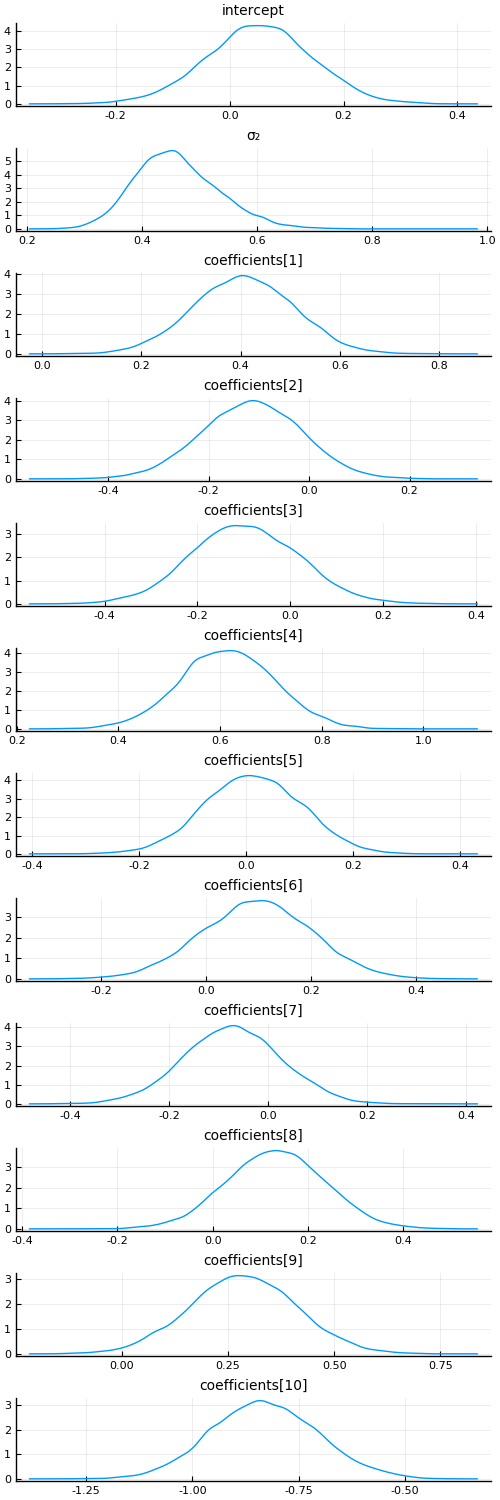

In [37]:
plot_variational_marginals(z, sym2range)

And let's compare this to using the `NUTS` sampler:

In [38]:
chain = sample(m, NUTS(0.65), 10_000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/cameron/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


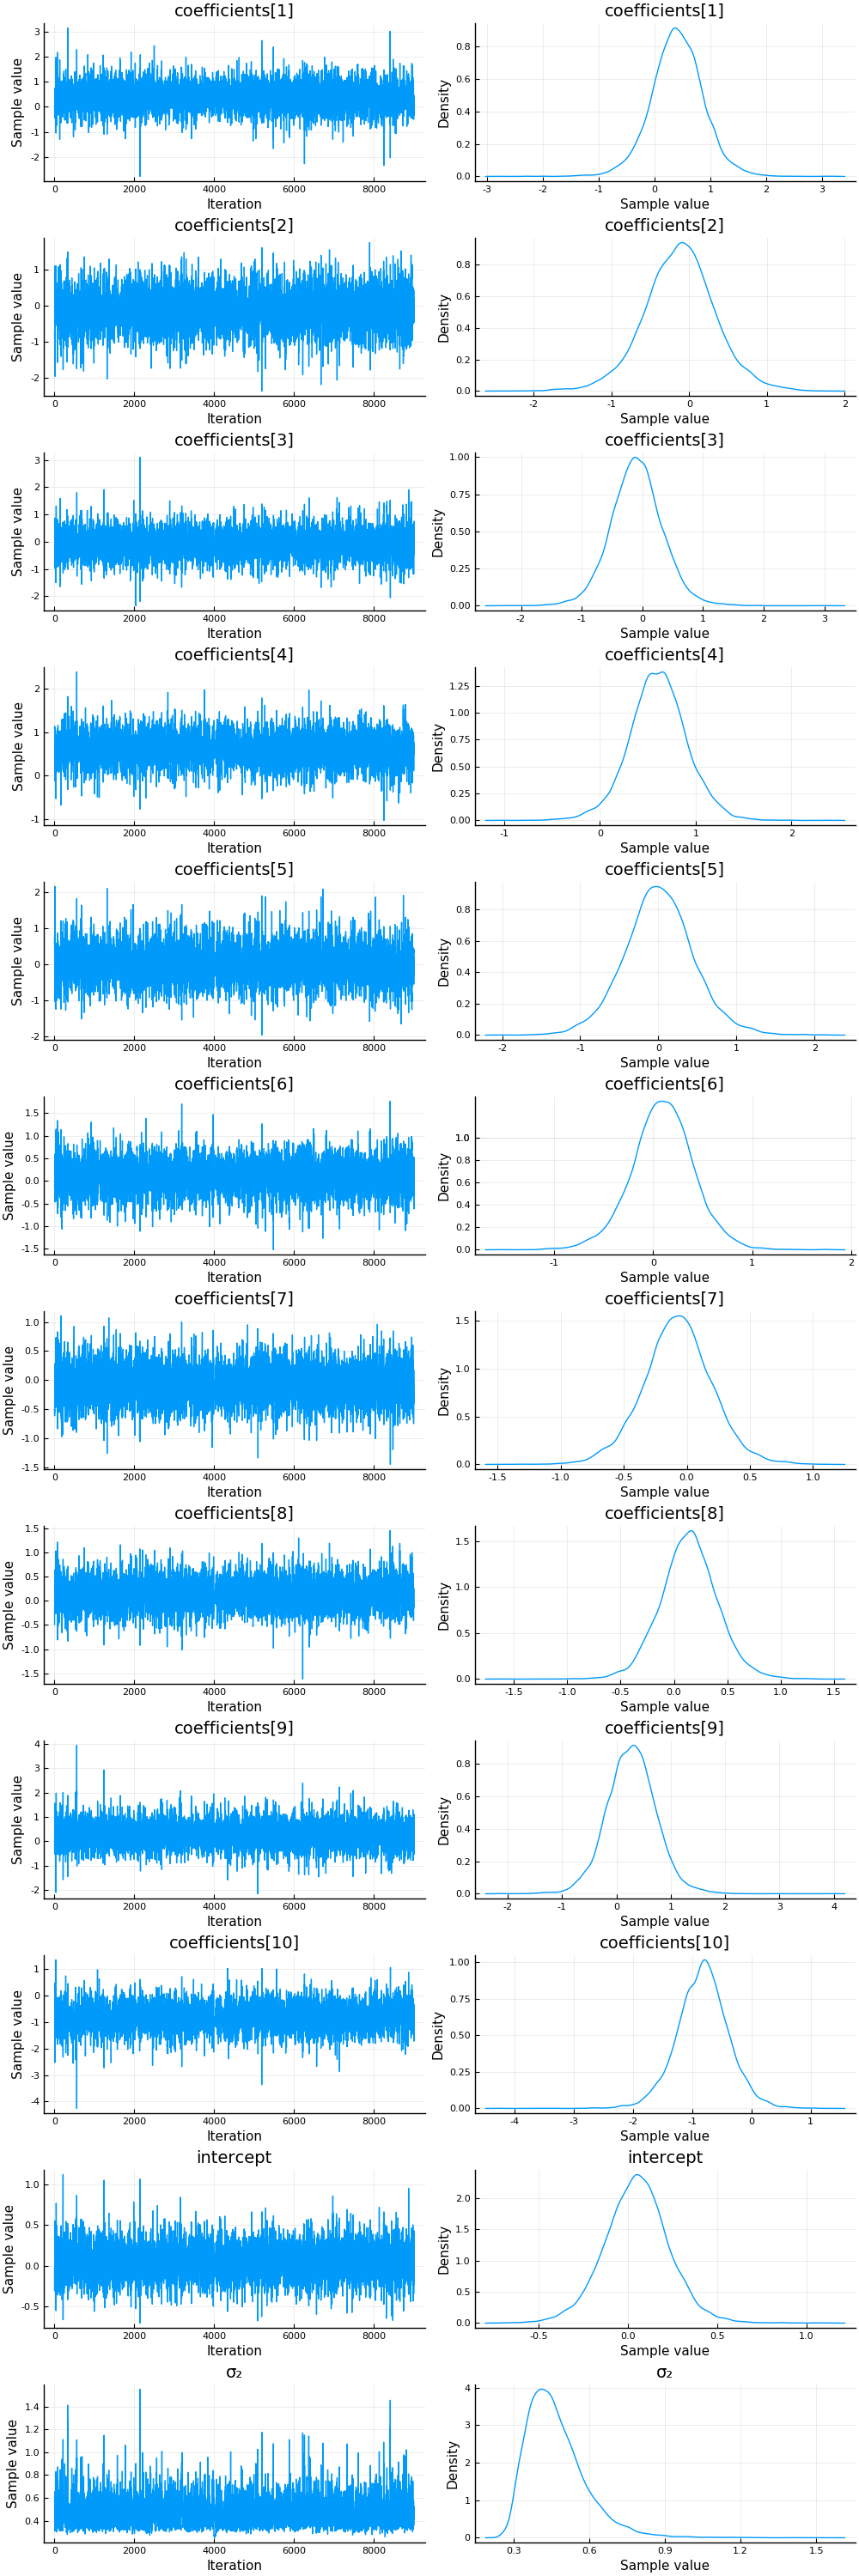

In [39]:
plot(chain)

In [40]:
vi_mean = vec(mean(z; dims = 2))[[union(sym2range[:coefficients]...)..., union(sym2range[:intercept]...)..., union(sym2range[:σ₂]...)...]]

12-element Array{Float64,1}:
  0.4064267006145497
 -0.11468688188714653
 -0.09745310785481277
  0.6148587707658169
  0.01308179579131569
  0.09698898180610954
 -0.07232304322690832
  0.13320265040493984
  0.28561578772443025
 -0.829825963610117
  0.05202909837745655
  0.4606389176400052

In [41]:
mean(chain).nt.mean

12-element Array{Float64,1}:
  0.40737234076000634
 -0.12119407949255825
 -0.09258229213058687
  0.6075161662165318
  0.010710254061742489
  0.0962666098260057
 -0.07340041375352217
  0.14124748712473906
  0.2782293300542158
 -0.8234179979734787
  0.049650076749642606
  0.47011974512236054

One thing we can look at is simply the squared error between the means:

In [42]:
sum(abs2, mean(chain).nt.mean .- vi_mean)

0.00038407031406971286

That looks pretty good! But let's see how the predictive distributions looks for the two.

## Prediction

Similarily to the linear regression tutorial, we're going to compare to multivariate ordinary linear regression using the `GLM` package:

In [43]:
# Import the GLM package.
using GLM

# Perform multivariate OLS.
ols = lm(@formula(MPG ~ Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb), train_cut)

# Store our predictions in the original dataframe.
train_cut.OLSPrediction = unstandardize(GLM.predict(ols), data.MPG);
test_cut.OLSPrediction = unstandardize(GLM.predict(ols, test_cut), data.MPG);

In [44]:
# Make a prediction given an input vector.
function prediction_chain(chain, x)
    p = get_params(chain)
    α = mean(p.intercept)
    β = collect(mean.(p.coefficients))
    return  α .+ x * β
end

prediction_chain (generic function with 1 method)

In [45]:
# Make a prediction using samples from the variational posterior given an input vector.
function prediction(samples::AbstractVector, sym2ranges, x)
    α = mean(samples[union(sym2ranges[:intercept]...)])
    β = vec(mean(samples[union(sym2ranges[:coefficients]...)]; dims = 2))
    return  α .+ x * β
end

function prediction(samples::AbstractMatrix, sym2ranges, x)
    α = mean(samples[union(sym2ranges[:intercept]...), :])
    β = vec(mean(samples[union(sym2ranges[:coefficients]...), :]; dims = 2))
    return  α .+ x * β
end

prediction (generic function with 2 methods)

In [46]:
# Unstandardize the dependent variable.
train_cut.MPG = unstandardize(train_cut.MPG, data.MPG);
test_cut.MPG = unstandardize(test_cut.MPG, data.MPG);

In [47]:
# Show the first side rows of the modified dataframe.
first(test_cut, 6)

,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,116.195,1.01488,0.591245,0.0483133,-0.835198,0.222544,-0.307089,-0.868028
2,114.295,1.01488,0.962396,1.4339,0.249566,0.636461,-1.36476,-0.868028
3,120.195,1.01488,1.36582,0.412942,-0.966118,0.641571,-0.446992,-0.868028
4,128.295,-1.22486,-1.22417,-1.17684,0.904164,-1.31048,0.588295,1.11604
5,126.995,-1.22486,-0.890939,-0.812211,1.55876,-1.10097,-0.642858,-0.868028
6,131.395,-1.22486,-1.09427,-0.491337,0.324377,-1.74177,-0.530935,1.11604


In [48]:
z = rand(q, 10_000);

In [49]:
# Calculate the predictions for the training and testing sets using the samples `z` from variational posterior
train_cut.VIPredictions = unstandardize(prediction(z, sym2range, train), data.MPG);
test_cut.VIPredictions = unstandardize(prediction(z, sym2range, test), data.MPG);

train_cut.BayesPredictions = unstandardize(prediction_chain(chain, train), data.MPG);
test_cut.BayesPredictions = unstandardize(prediction_chain(chain, test), data.MPG);

In [50]:
vi_loss1 = mean((train_cut.VIPredictions - train_cut.MPG).^2)
bayes_loss1 = mean((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = mean((train_cut.OLSPrediction - train_cut.MPG).^2)

vi_loss2 = mean((test_cut.VIPredictions - test_cut.MPG).^2)
bayes_loss2 = mean((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = mean((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:
    VI loss: $vi_loss1
    Bayes loss: $bayes_loss1
    OLS loss: $ols_loss1
Test set: 
    VI loss: $vi_loss2
    Bayes loss: $bayes_loss2
    OLS loss: $ols_loss2")

Training set:
    VI loss: 3.0784608943296643
    Bayes loss: 3.0716118391411906
    OLS loss: 3.070926124893019
Test set: 
    VI loss: 27.159605003619333
    Bayes loss: 26.58835451660728
    OLS loss: 27.094813070760107


Interestingly the squared difference between true- and mean-prediction on the test-set is actually *better* for the mean-field variational posterior than for the "true" posterior obtained by MCMC sampling using `NUTS`. But, as Bayesians, we know that the mean doesn't tell the entire story. One quick check is to look at the mean predictions ± standard deviation of the two different approaches:

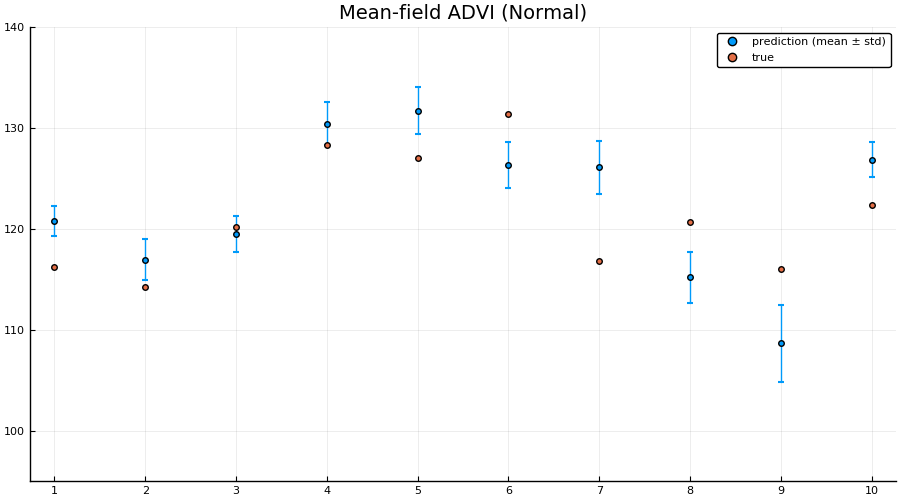

In [51]:
z = rand(q, 1000);
preds = hcat([unstandardize(prediction(z[:, i], sym2range, test), data.MPG) for i = 1:size(z, 2)]...);

scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="prediction (mean ± std)", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="true")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("Mean-field ADVI (Normal)")

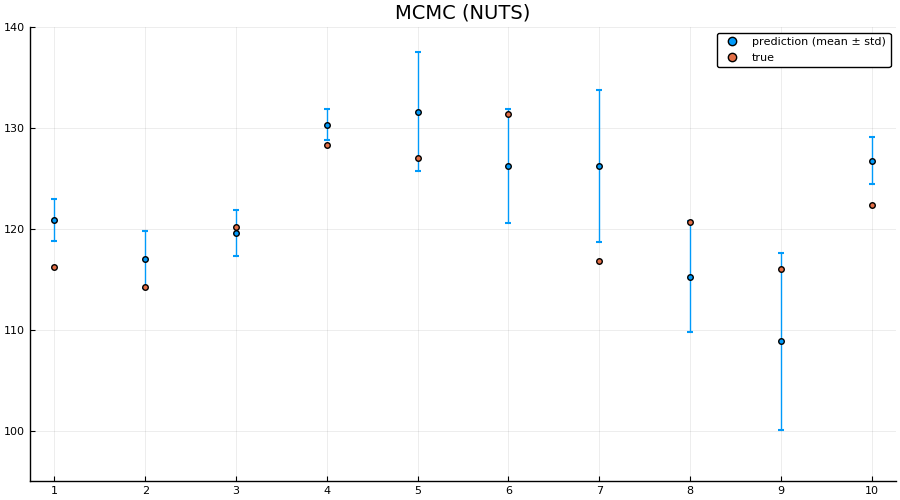

In [52]:
preds = hcat([unstandardize(prediction_chain(chain[i], test), data.MPG) for i = 1:5:size(chain, 1)]...);

scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="prediction (mean ± std)", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="true")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("MCMC (NUTS)")

Indeed we see that the MCMC approach generally provides better uncertainty estimates than the mean-field ADVI approach! Good. So all the work we've done to make MCMC fast isn't for nothing.

## Alternative: provide parameter-to-distribution instead of `q` with`update` implemented

As mentioned earlier, it's also possible to just provide the mapping $\theta \mapsto q_{\theta}$ rather than the variational family / initial variational posterior `q`, i.e. use the interface `vi(m, advi, getq, θ_init)` where `getq` is the mapping $\theta \mapsto q_{\theta}$

In this section we're going to construct a mean-field approximation to the model by hand using a composition of`Shift` and `Scale` from Bijectors.jl togheter with a standard multivariate Gaussian as the base distribution. 

In [53]:
using Bijectors

In [54]:
using Bijectors: Scale, Shift

In [55]:
d = length(q)
base_dist = Turing.DistributionsAD.TuringDiagMvNormal(zeros(d), ones(d))

DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
σ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
)


`bijector(model::Turing.Model)` is defined by Turing, and will return a `bijector` which takes you from the space of the latent variables to the real space. In this particular case, this is a mapping `((0, ∞) × ℝ × ℝ¹⁰) → ℝ¹²`. We're interested in using a normal distribution as a base-distribution and transform samples to the latent space, thus we need the inverse mapping from the reals to the latent space:

In [56]:
to_constrained = inv(bijector(m));

In [57]:
function getq(θ)
    d = length(θ) ÷ 2
    A = @inbounds θ[1:d]
    b = @inbounds θ[d + 1: 2 * d]
    
    b = to_constrained ∘ Shift(b; dim = Val(1)) ∘ Scale(exp.(A); dim = Val(1))
    
    return transformed(base_dist, b)
end

getq (generic function with 1 method)

In [58]:
q_mf_normal = vi(m, advi, getq, randn(2 * d));

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 8127634262038331167
└ @ Turing.Variational /home/cameron/.julia/packages/Turing/cReBm/src/variational/VariationalInference.jl:204
[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:06


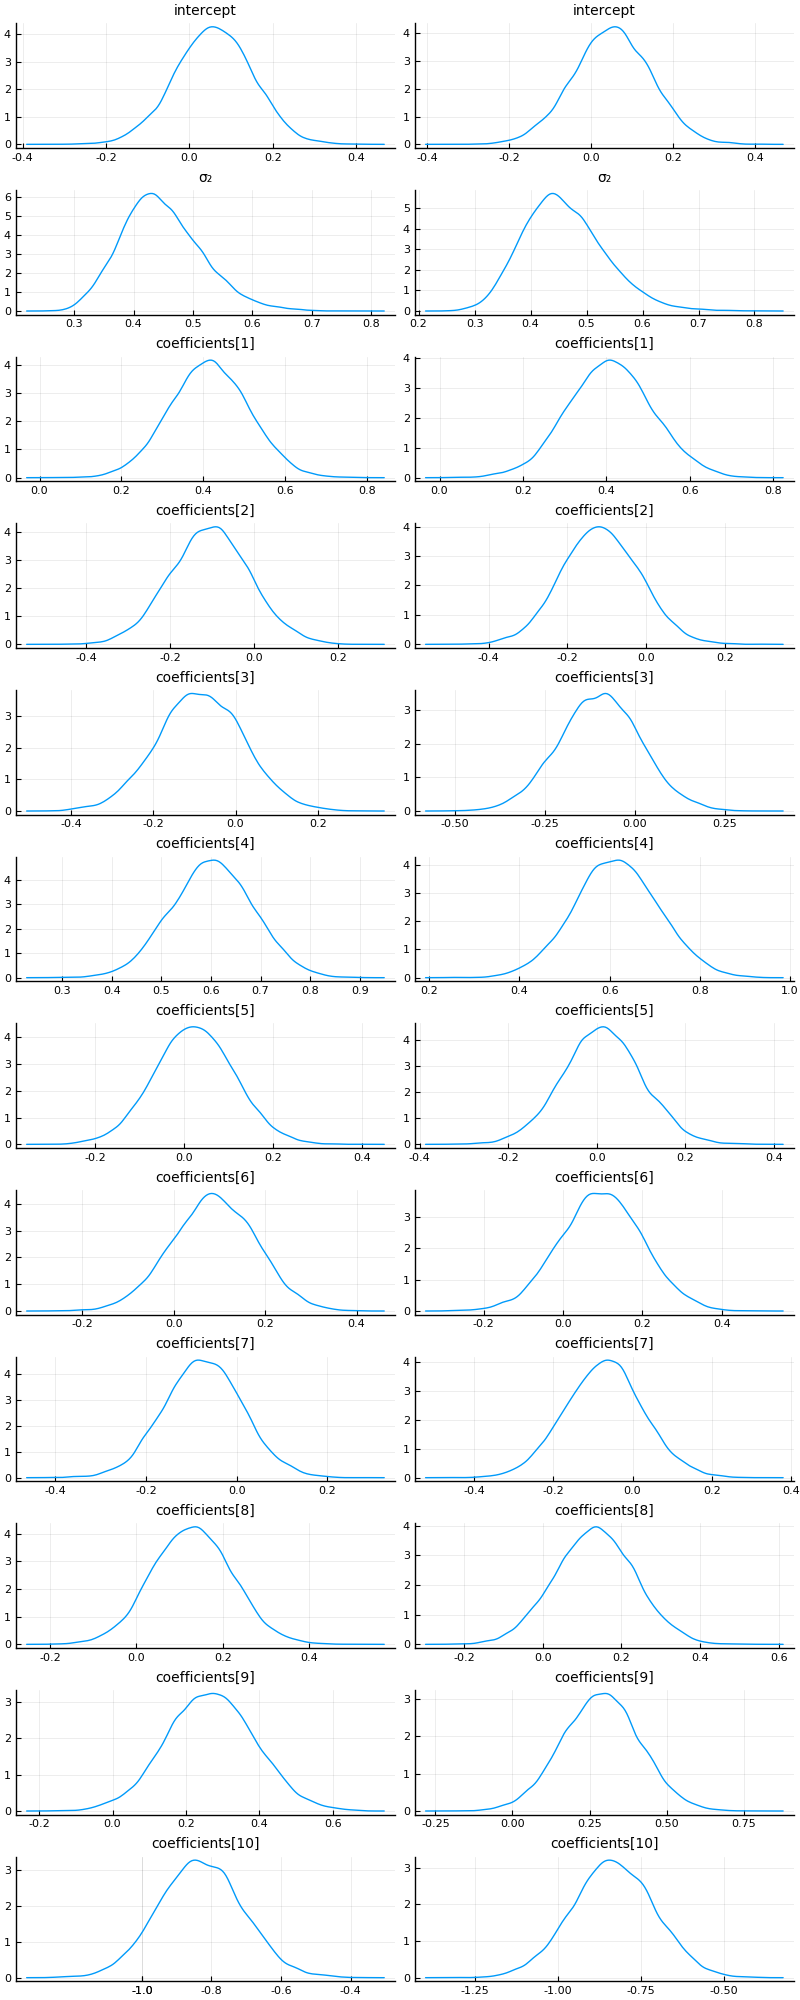

In [59]:
p1 = plot_variational_marginals(rand(q_mf_normal, 10_000), sym2range) # MvDiagNormal + Affine transformation + to_constrained
p2 = plot_variational_marginals(rand(q, 10_000), sym2range)  # Turing.meanfield(m)

plot(p1, p2, layout = (1, 2), size = (800, 2000))

As expected, the fits look pretty much identical.

But using this interface it becomes trivial to go beyond the mean-field assumption we made for the variational posterior, as we'll see in the next section.

### Relaxing the mean-field assumption

Here we'll instead consider the variational family to be a full non-diagonal multivariate Gaussian. As in the previous section we'll implement this by transforming a standard multivariate Gaussian using `Scale` and `Shift`, but now `Scale` will instead be using a lower-triangular matrix (representing the Cholesky of the covariance matrix of a multivariate normal) in constrast to the diagonal matrix we used in for the mean-field approximate posterior.

In [60]:
using LinearAlgebra

In [61]:
d = 12

function getq(θ)
    offset = 0
    L = LowerTriangular(reshape(@inbounds(θ[offset + 1: offset + d^2]), (d, d)))
    offset += d^2
    b = @inbounds θ[offset + 1: offset + d]
    
    # For this to represent a covariance matrix we need to ensure that the diagonal is positive.
    # We can enforce this by zeroing out the diagonal and then adding back the diagonal exponentiated.
    D = Diagonal(diag(L))
    A = L - D + exp(D) # exp for Diagonal is the same as exponentiating only the diagonal entries
    
    b = to_constrained ∘ Shift(b; dim = Val(1)) ∘ Scale(A; dim = Val(1))
    
    return transformed(base_dist, b)
end

getq (generic function with 1 method)

In [62]:
advi = ADVI(10, 20_000)

ADVI{Turing.Core.ForwardDiffAD{40}}(10, 20000)

In [63]:
q_full_normal = vi(m, advi, getq, randn(d^2 + d); optimizer = Variational.DecayedADAGrad(1e-2));

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:01:05


Let's have a look at the learned covariance matrix:

In [64]:
A = q_full_normal.transform.ts[1].a

12×12 LowerTriangular{Float64,Array{Float64,2}}:
  0.154572       ⋅           ⋅          …    ⋅           ⋅           ⋅ 
  0.00674249    0.169072     ⋅               ⋅           ⋅           ⋅ 
 -0.00288782   -0.0283984   0.413288         ⋅           ⋅           ⋅ 
 -0.030621      0.0450533  -0.0415525        ⋅           ⋅           ⋅ 
 -0.0115003     0.208366   -0.0420414        ⋅           ⋅           ⋅ 
  0.00139553   -0.0619506   0.0853589   …    ⋅           ⋅           ⋅ 
  0.0129097    -0.0647154   0.00228644       ⋅           ⋅           ⋅ 
 -0.0128701    -0.0531755   0.0999936        ⋅           ⋅           ⋅ 
  0.00169318    0.0274239   0.0903744        ⋅           ⋅           ⋅ 
 -0.0172387    -0.0304655   0.0661713       0.14843      ⋅           ⋅ 
 -0.000468924   0.300281    0.0789093   …  -0.131391    0.128256     ⋅ 
  0.00160201   -0.122274   -0.0776935       0.0468996  -0.00752499  0.120458

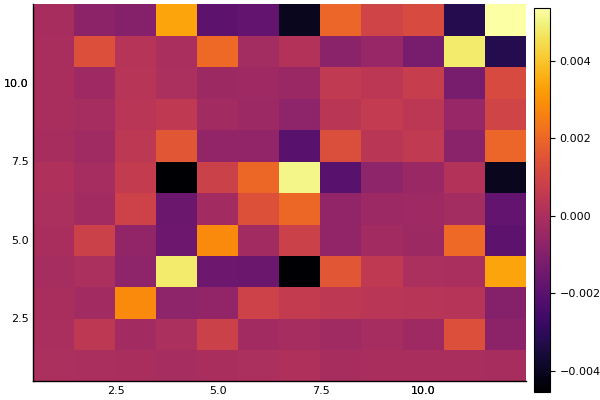

In [65]:
heatmap(cov(A * A'))

In [66]:
zs = rand(q_full_normal, 10_000);

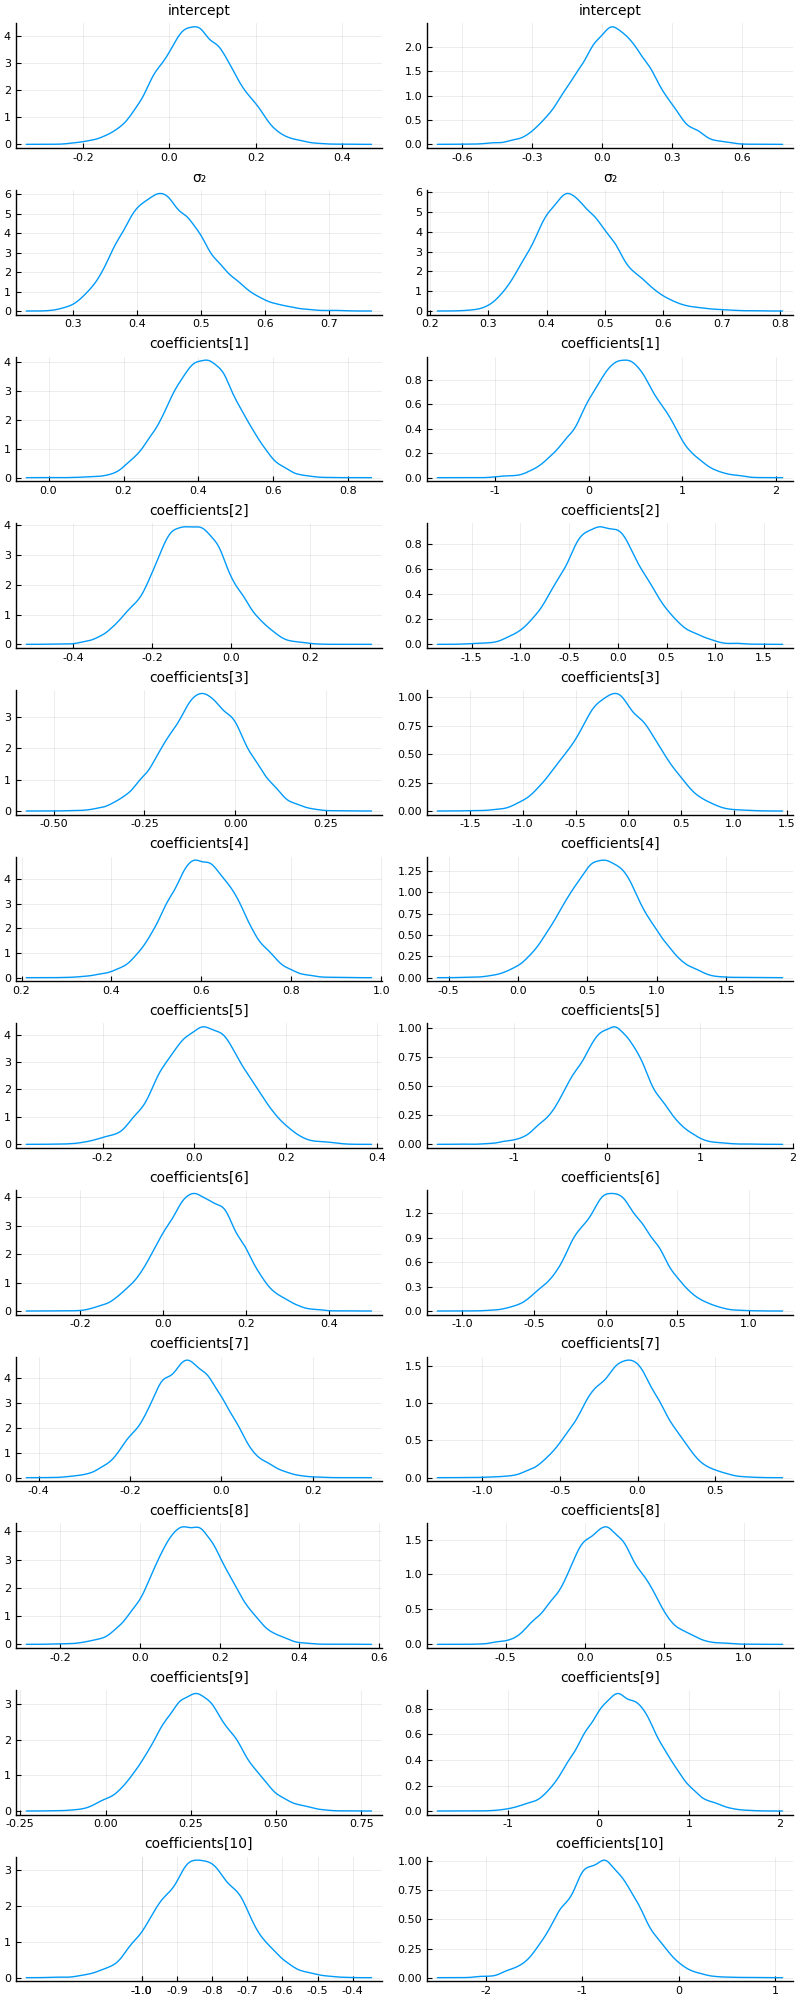

In [67]:
p1 = plot_variational_marginals(rand(q_mf_normal, 10_000), sym2range)
p2 = plot_variational_marginals(rand(q_full_normal, 10_000), sym2range)

plot(p1, p2, layout = (1, 2), size = (800, 2000))

So it seems like the "full" ADVI approach, i.e. no mean-field assumption, obtain the same modes as the mean-field approach but with greater uncertainty for some of the `coefficients`. This 

In [68]:
# Unfortunately, it seems like this has quite a high variance which is likely to be due to numerical instability, 
# so we consider a larger number of samples. If we get a couple of outliers due to numerical issues, 
# these kind affect the mean prediction greatly.
z = rand(q_full_normal, 10_000);

In [69]:
train_cut.VIFullPredictions = unstandardize(prediction(z, sym2range, train), data.MPG);
test_cut.VIFullPredictions = unstandardize(prediction(z, sym2range, test), data.MPG);

In [70]:
vi_loss1 = mean((train_cut.VIPredictions - train_cut.MPG).^2)
vifull_loss1 = mean((train_cut.VIFullPredictions - train_cut.MPG).^2)
bayes_loss1 = mean((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = mean((train_cut.OLSPrediction - train_cut.MPG).^2)

vi_loss2 = mean((test_cut.VIPredictions - test_cut.MPG).^2)
vifull_loss2 = mean((test_cut.VIFullPredictions - test_cut.MPG).^2)
bayes_loss2 = mean((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = mean((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:
    VI loss:        $vi_loss1
    VI (full) loss: $vifull_loss1
    Bayes loss:     $bayes_loss1
    OLS loss:       $ols_loss1
Test set: 
    VI loss:        $vi_loss2
    VI (full) loss: $vifull_loss2
    Bayes loss:     $bayes_loss2
    OLS loss:       $ols_loss2")

Training set:
    VI loss:        3.0784608943296643
    VI (full) loss: 3.0926834377972288
    Bayes loss:     3.0716118391411906
    OLS loss:       3.070926124893019
Test set: 
    VI loss:        27.159605003619333
    VI (full) loss: 26.912162732716684
    Bayes loss:     26.58835451660728
    OLS loss:       27.094813070760107


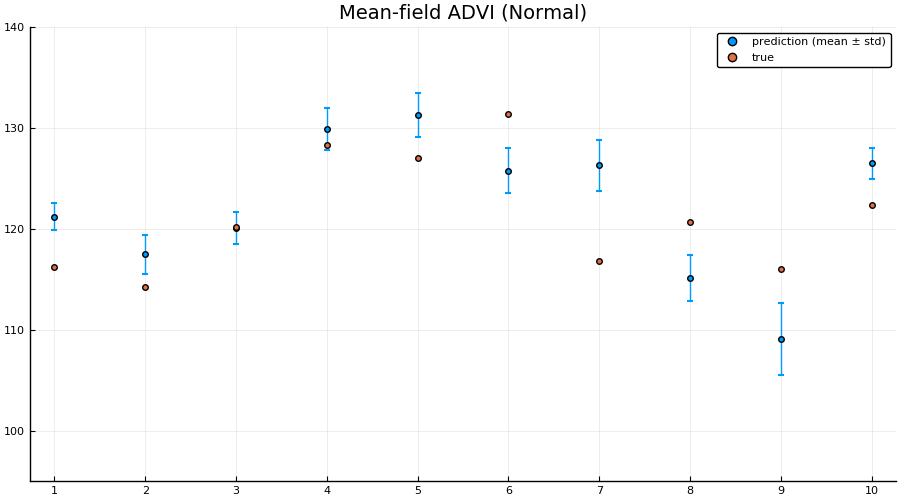

In [71]:
z = rand(q_mf_normal, 1000);
preds = hcat([unstandardize(prediction(z[:, i], sym2range, test), data.MPG) for i = 1:size(z, 2)]...);

p1 = scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="prediction (mean ± std)", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="true")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("Mean-field ADVI (Normal)")

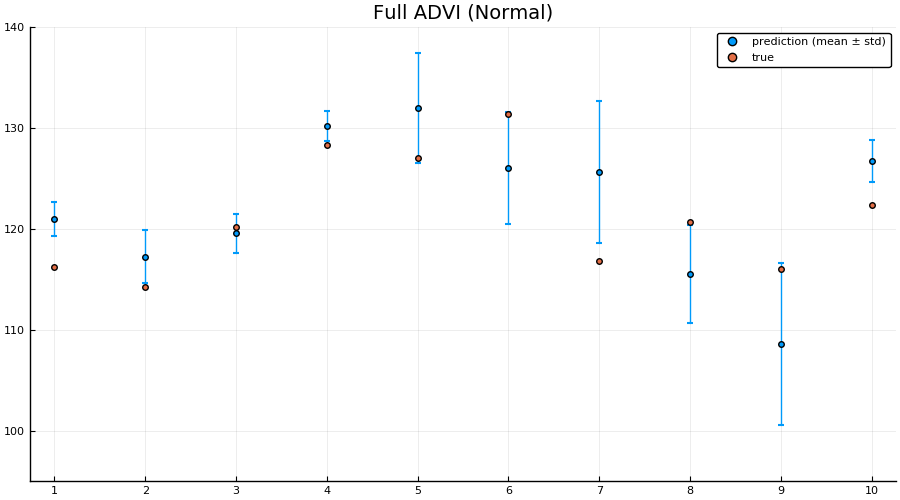

In [72]:
z = rand(q_full_normal, 1000);
preds = hcat([unstandardize(prediction(z[:, i], sym2range, test), data.MPG) for i = 1:size(z, 2)]...);

p2 = scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="prediction (mean ± std)", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="true")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("Full ADVI (Normal)")

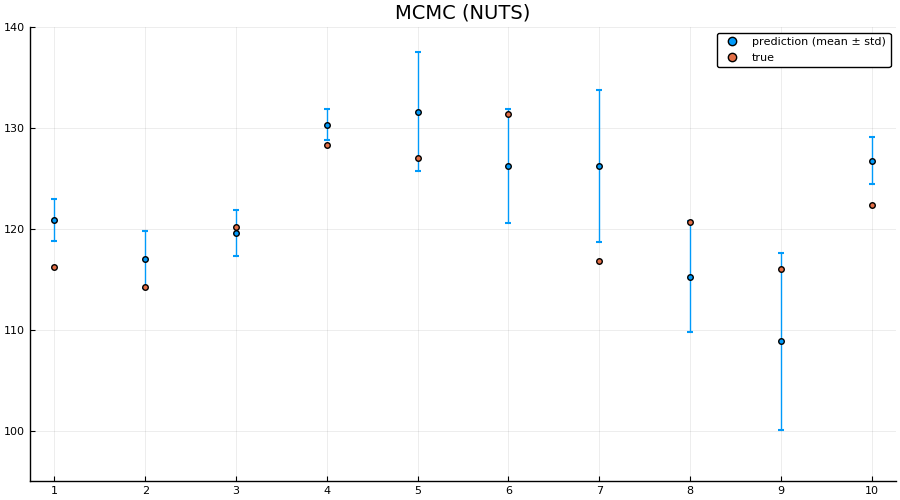

In [73]:
preds = hcat([unstandardize(prediction_chain(chain[i], test), data.MPG) for i = 1:5:size(chain, 1)]...);

p3 = scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="prediction (mean ± std)", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="true")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("MCMC (NUTS)")

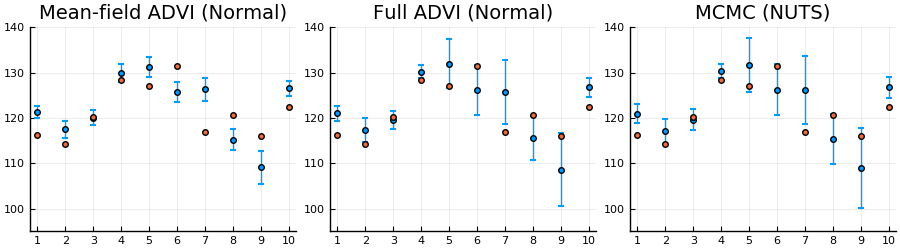

In [74]:
plot(p1, p2, p3, layout = (1, 3), size = (900, 250), label="")

Here we actually see that indeed both the full ADVI and the MCMC approaches does a much better job of quantifying the uncertainty of predictions for never-before-seen samples, with full ADVI seemingly *overestimating* the variance slightly compared to MCMC.

So now you know how to do perform VI on your Turing.jl model! Great isn't it?